#                          Project : Personalized Medicine: Redefining Cancer Treatment

# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

https://www.kaggle.com/c/msk-redefining-cancer-treatment

In [101]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [4]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

In [6]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [8]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [9]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [10]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [11]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [12]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [13]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [14]:
# checking the dimentions
data_text.shape

(3321, 2)

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [15]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. ( like which variables are affecting for patients)

We will evaluate our model using Confution matrix and Multi class log-loss

In [16]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
stop_words = set(stopwords.words('english'))

In [17]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [18]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [19]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. 

One way could be that we can drop these rows having missing values or we can do some imputation in it. 

Here we are going with imputation methods by merging Gene and Variation column.

In [21]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [22]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


## Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [23]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [24]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [25]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [27]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

In [28]:
train_class_distribution

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 7 values with count of 609, class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

*** Visualizing for train class distrubution***

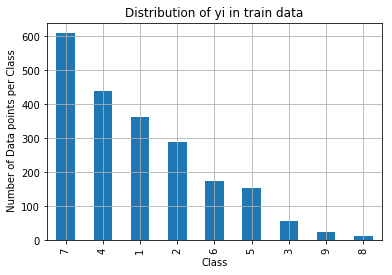

In [29]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [30]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 609 ( 28.672 %)
Number of data points in class 2 : 439 ( 20.669 %)
Number of data points in class 3 : 363 ( 17.09 %)
Number of data points in class 4 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 6 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 8 : 24 ( 1.13 %)
Number of data points in class 9 : 12 ( 0.565 %)


Let's visualize the same for test set

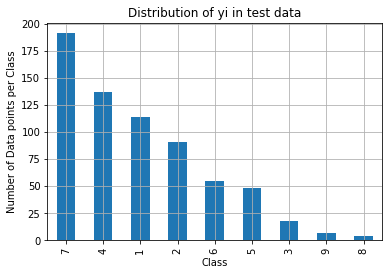

In [31]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [32]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 191 ( 28.722 %)
Number of data points in class 2 : 137 ( 20.602 %)
Number of data points in class 3 : 114 ( 17.143 %)
Number of data points in class 4 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 6 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 8 : 7 ( 1.053 %)
Number of data points in class 9 : 4 ( 0.602 %)


Let's visualize for cross validation set

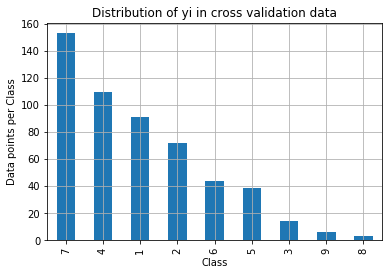

In [33]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [34]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 153 ( 28.759 %)
Number of data points in class 2 : 110 ( 20.677 %)
Number of data points in class 3 : 91 ( 17.105 %)
Number of data points in class 4 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 6 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 8 : 6 ( 1.128 %)
Number of data points in class 9 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this. So, what are you waiting for. Always have a bg smile while solving Machine learning problems :). That helps!!

## Building a Random model

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [35]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

initialise every class as 0

for loop iteration for the length of 9 that is cv data length

it will generate random values between 1 to 9 for the length of 9 that is 9 iterations

and we will predict the probabilities for each iteration

find the overall log loss by comparing with cross validation class data

In [36]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))  
# initialise every class as 0
for i in range(cv_data_len): 
    rand_probs = np.random.rand(1,9)  
    # it will generate random values between 1 to 9 for the length of 9 that is 9 iterations
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    # and we will predict the probabilities for each iteration 
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))
# find the overall log loss by comparing with original data

Log loss on Cross Validation Data using Random Model 2.5245003170567193


#### if we got log log loss above this vlaue for our original model then that is the worst model

Similarly we do it for test set

In [37]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.441816437058127


In [38]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [39]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([0, 2, 6, 7, 0, 1, 2, 0, 4, 1, 7, 5, 3, 5, 6, 1, 4, 3, 2, 2, 8, 1,
       7, 2, 8, 2, 1, 5, 4, 8, 7, 6, 4, 6, 5, 0, 6, 4, 6, 8, 5, 3, 1, 4,
       3, 1, 3, 5, 7, 5, 5, 3, 2, 1, 4, 4, 6, 5, 3, 7, 8, 7, 4, 3, 8, 1,
       8, 5, 6, 7, 6, 3, 2, 4, 5, 8, 7, 3, 0, 5, 5, 8, 1, 8, 5, 5, 2, 7,
       5, 5, 7, 4, 1, 8, 7, 7, 1, 7, 3, 5, 2, 2, 7, 0, 1, 7, 1, 0, 6, 0,
       0, 0, 5, 6, 6, 0, 2, 1, 7, 3, 6, 6, 8, 5, 7, 4, 7, 1, 3, 2, 8, 7,
       0, 7, 3, 4, 6, 1, 0, 2, 6, 1, 5, 7, 8, 5, 2, 8, 7, 3, 8, 5, 2, 0,
       7, 3, 0, 1, 1, 1, 2, 3, 1, 7, 2, 8, 8, 2, 5, 5, 4, 4, 1, 4, 0, 7,
       8, 2, 0, 0, 7, 0, 5, 1, 6, 8, 7, 6, 5, 1, 1, 0, 1, 4, 7, 2, 1, 6,
       0, 5, 6, 0, 8, 5, 8, 8, 7, 1, 6, 6, 4, 1, 5, 1, 4, 2, 5, 2, 7, 8,
       3, 8, 8, 7, 4, 6, 1, 4, 4, 4, 2, 3, 7, 1, 4, 7, 0, 0, 6, 8, 8, 2,
       2, 8, 4, 3, 4, 8, 2, 4, 3, 6, 3, 8, 7, 2, 7, 1, 5, 3, 4, 1, 1, 4,
       2, 1, 3, 3, 2, 8, 7, 8, 5, 4, 1, 8, 7, 7, 3, 2, 0, 5, 7, 8, 8, 3,
       4, 3, 5, 3, 0, 4, 0, 4, 0, 6, 6, 3, 3, 3, 2,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [40]:
predicted_y = predicted_y + 1

### Confusion Matrix

In [41]:
C = confusion_matrix(y_test, predicted_y)


 we need the diagonal elements to be high other than this diagonal line all are errors 

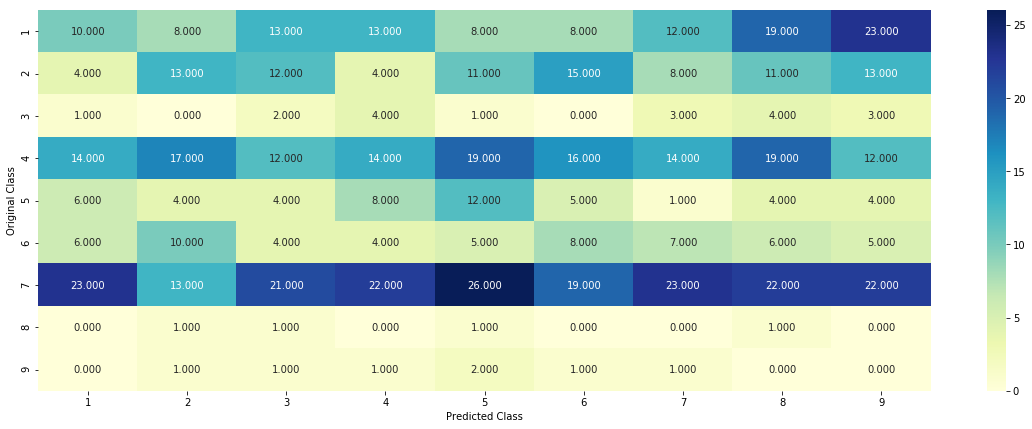

In [42]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Precision matrix

Ratio of correctly predicted positive to the total predicted positive observations.

In [43]:
B =(C/C.sum(axis=0))

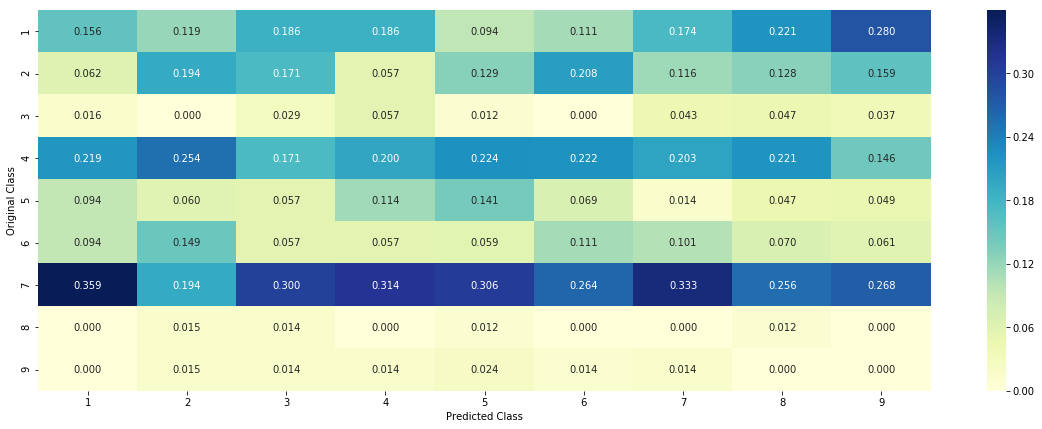

In [44]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

of all the class belongs to class 1, 17.1 % belongs to actually class 1

of all the class belongs to class 1 ,12.2% actually belongs to class 6

### Recall matrix ( True Positive Rate )

In [45]:
A =(((C.T)/(C.sum(axis=1))).T)

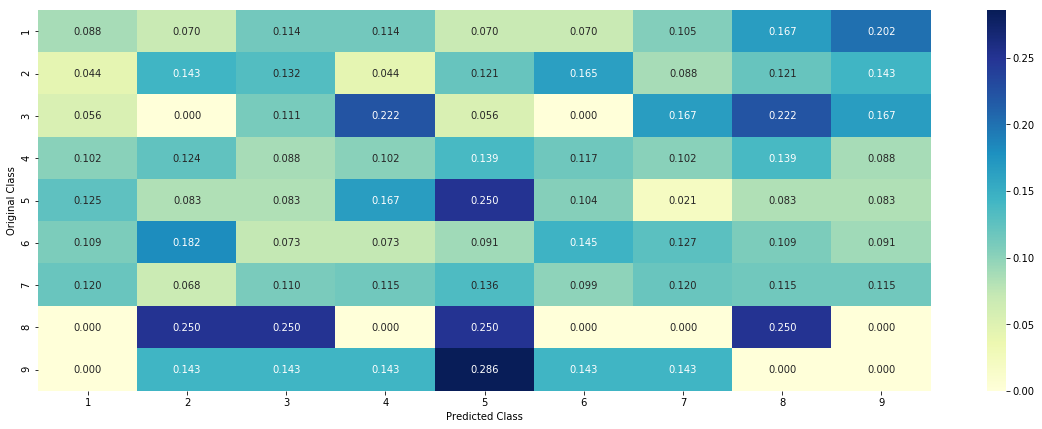

In [46]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column ***Gene*** and lets look at its distribution. 

In [47]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 232
BRCA1     166
TP53      104
EGFR       85
PTEN       82
BRCA2      80
KIT        62
BRAF       56
ERBB2      47
ALK        43
PDGFRA     43
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [48]:
unique_genes.shape[0]

232

Lets look at the comulative distribution of unique Genes values

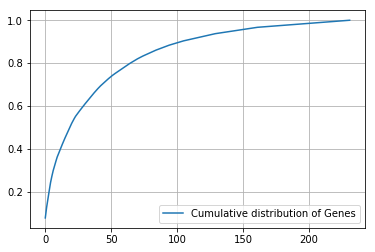

In [49]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

almost 75% of data are covered by top 50 genes

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

##### Word Counts with CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

In [50]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [51]:
train_gene_feature_onehotCoding.shape

(2124, 232)

In [52]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hras',
 'idh1',
 'idh2',
 'igf1r'

In [53]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [54]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.4059953680007178
For values of alpha =  0.0001 The log loss is: 1.2266698716532556
For values of alpha =  0.001 The log loss is: 1.2267394376614866
For values of alpha =  0.01 The log loss is: 1.3215337643325744
For values of alpha =  0.1 The log loss is: 1.39953831305138
For values of alpha =  1 The log loss is: 1.4320792594443605


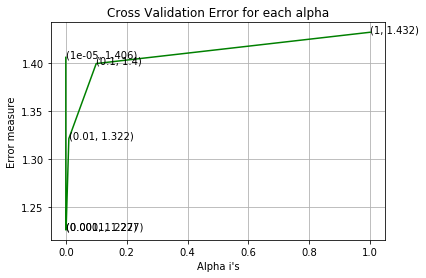

In [55]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [56]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0362782899577787
For values of best alpha =  0.0001 The cross validation log loss is: 1.2266698716532556
For values of best alpha =  0.0001 The test log loss is: 1.1880564686356776


Now lets check how many values are overlapping between train, test or between CV and train

In [57]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [58]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 514 out of  532 : 96.61654135338345


## Evaluating Variation column

Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [59]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1927
Truncating_Mutations    59
Amplification           46
Deletion                46
Fusions                 19
Overexpression           5
G12V                     3
Q61R                     3
T286A                    2
K117N                    2
T58I                     2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique ***variation*** values

[0.02777778 0.04943503 0.07109228 ... 0.99905838 0.99952919 1.        ]


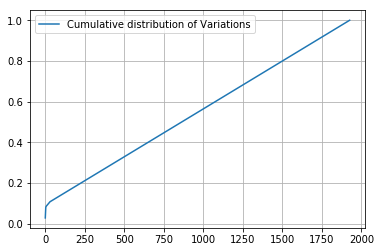

In [60]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [61]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [62]:
train_variation_feature_onehotCoding.shape

(2124, 1957)

Lets again build the model with only column name of ***variation*** column

In [63]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [64]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.712639784246851
For values of alpha =  0.0001 The log loss is: 1.700491873198474
For values of alpha =  0.001 The log loss is: 1.7026666597650253
For values of alpha =  0.01 The log loss is: 1.716400680650902
For values of alpha =  0.1 The log loss is: 1.7248149890324593
For values of alpha =  1 The log loss is: 1.7268965256198026


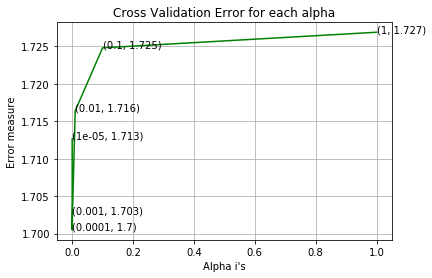

In [65]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [66]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7348632652279464
For values of best alpha =  0.0001 The cross validation log loss is: 1.700491873198474
For values of best alpha =  0.0001 The test log loss is: 1.6969359001092128


In [67]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [68]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 66 out of 665 : 9.924812030075188
2. In cross validation data 56 out of  532 : 10.526315789473683


## Evaluating Text column

In [69]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [70]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53652


In [71]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [72]:
#normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [73]:
#source: https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [74]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5801, 4: 3610, 6: 2636, 5: 2634, 7: 2468, 8: 1869, 9: 1757, 10: 1560, 12: 1384, 13: 1066, 14: 1008, 11: 988, 15: 877, 16: 872, 20: 684, 18: 655, 17: 532, 22: 515, 24: 507, 21: 483, 19: 438, 23: 415, 25: 413, 28: 363, 30: 345, 44: 342, 27: 341, 26: 336, 31: 330, 33: 308, 32: 286, 50: 284, 40: 276, 35: 264, 36: 260, 29: 249, 34: 224, 39: 216, 37: 200, 48: 191, 41: 191, 38: 191, 42: 183, 60: 177, 45: 173, 46: 171, 51: 170, 43: 161, 49: 155, 47: 153, 56: 149, 53: 149, 57: 143, 52: 140, 54: 134, 58: 126, 55: 125, 65: 121, 63: 121, 59: 115, 62: 113, 61: 113, 72: 112, 66: 107, 64: 100, 80: 97, 71: 93, 82: 90, 68: 90, 100: 89, 70: 89, 67: 89, 74: 88, 75: 87, 69: 84, 90: 82, 73: 82, 78: 81, 84: 79, 88: 74, 96: 72, 108: 70, 76: 69, 77: 68, 85: 67, 91: 66, 105: 65, 120: 64, 95: 64, 104: 63, 93: 60, 98: 59, 79: 59, 99: 58, 92: 58, 81: 58, 97: 57, 87: 57, 94: 56, 83: 56, 86: 55, 115: 52, 110: 51, 103: 49, 101: 49, 102: 48, 150: 47, 111: 47, 89: 47, 130: 46, 118: 46, 138: 43, 126: 43, 12

Lets build the model with only ***text*** column

In [75]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    # we will compare our prediction with y_cv that is cross validation set
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.4226002499986268
For values of alpha =  0.0001 The log loss is: 1.3463862362998105
For values of alpha =  0.001 The log loss is: 1.2251160207715663
For values of alpha =  0.01 The log loss is: 1.2919443654852252
For values of alpha =  0.1 The log loss is: 1.5106723587613367
For values of alpha =  1 The log loss is: 1.6674934394955205


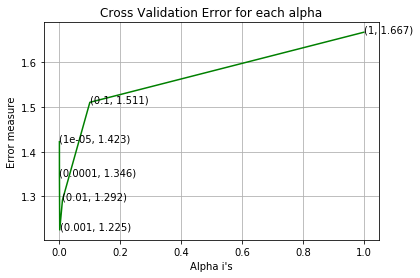

In [76]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [77]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7638431749446077
For values of best alpha =  0.001 The cross validation log loss is: 1.2251160207715663
For values of best alpha =  0.001 The test log loss is: 1.132329393195939


Lets check the overlap of text data

In [78]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [79]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.22 % of word of test data appeared in train data
97.773 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.

## Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [80]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [81]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [82]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [83]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [84]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55841)
(number of data points * number of features) in test data =  (665, 55841)
(number of data points * number of features) in cross validation data = (532, 55841)


# Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

# Naive Bayes

In [102]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
# predicing proba for cross validation points 

# train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
# test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr(
# cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
    
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.28252591461713
for alpha = 0.0001
Log Loss : 1.279881805194581
for alpha = 0.001
Log Loss : 1.2695195581624792
for alpha = 0.1
Log Loss : 1.291613267168383
for alpha = 1
Log Loss : 1.3302200682259493
for alpha = 10
Log Loss : 1.4025195871221623
for alpha = 100
Log Loss : 1.3876791216064748
for alpha = 1000
Log Loss : 1.3167002569801187


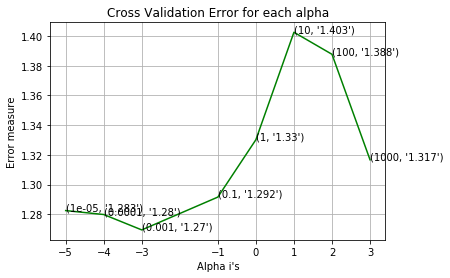

In [103]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [104]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_log_loss)



For values of best alpha =  0.001 The train log loss is: 0.8611817389256781
For values of best alpha =  0.001 The cross validation log loss is: 1.2695195581624792
For values of best alpha =  0.001 The test log loss is: 1.2434134523699512


In [105]:
results = pd.DataFrame([['Naive Bayes', alpha[best_alpha], train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.26952,1.243413


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2695195581624792
Number of missclassified point : 0.3966165413533835
-------------------- Confusion matrix --------------------


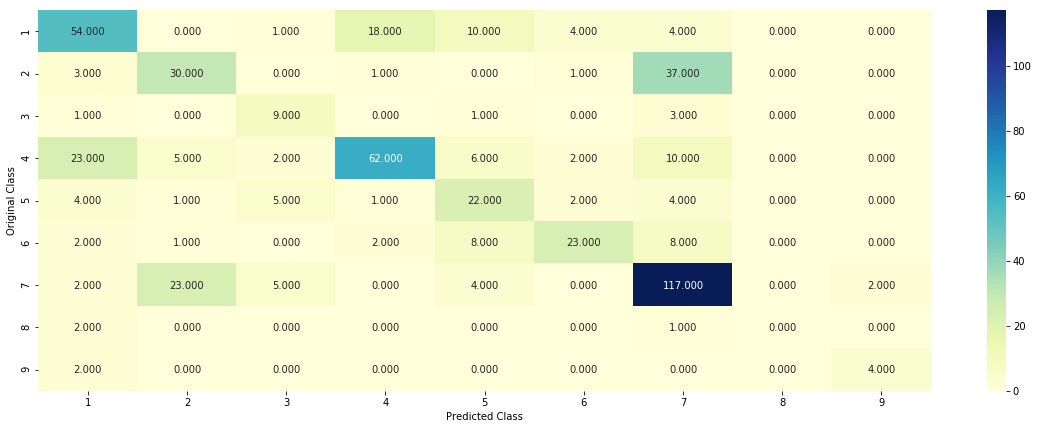

-------------------- Precision matrix (Columm Sum=1) --------------------


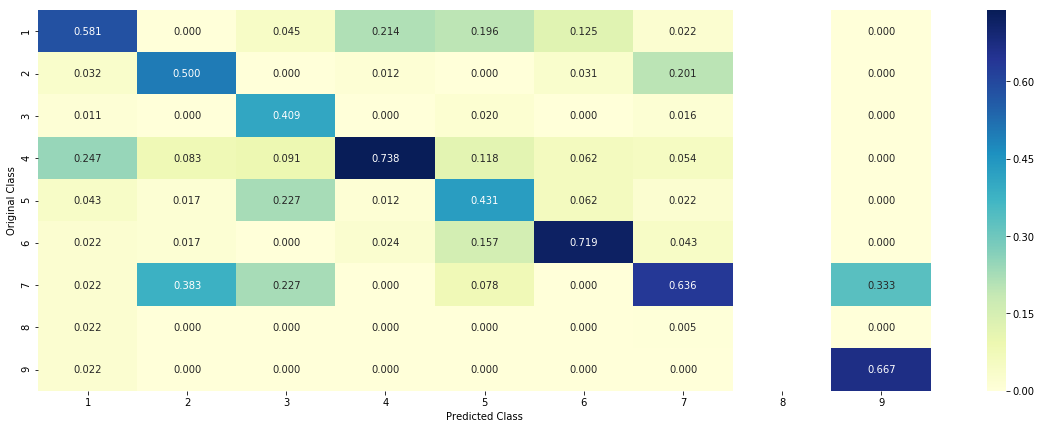

-------------------- Recall matrix (Row sum=1) --------------------


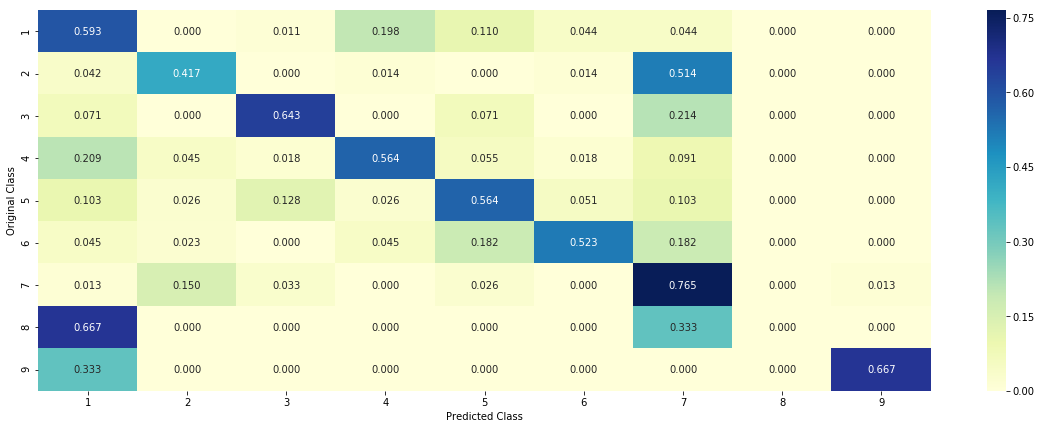

In [106]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [107]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4096 0.0854 0.0118 0.1136 0.039  0.0415 0.2893 0.0054 0.0044]]
Actual Class : 1
--------------------------------------------------
12 Text feature [dna] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [type] present in test data point [True]
15 Text feature [two] present in test data point [True]
16 Text feature [one] present in test data point [True]
17 Text feature [wild] present in test data point [True]
18 Text feature [affect] present in test data point [True]
19 Text feature [protein] present in test data point [True]
20 Text feature [loss] present in test data point [True]
21 Text feature [present] present in test data point [True]
22 Text feature [sequences] present in test data point [True]
23 Text feature [remaining] present in test data point [True]
24 Text feature [large] present in test data point [True]
25 Text feature [functions] present in test data poin

Lets look at one more point

In [108]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0849 0.0803 0.0111 0.1052 0.0362 0.0389 0.6341 0.0051 0.0041]]
Actual Class : 7
--------------------------------------------------
17 Text feature [kinase] present in test data point [True]
18 Text feature [presence] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [potential] present in test data point [True]
22 Text feature [contrast] present in test data point [True]
23 Text feature [activation] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
28 Text feature [well] present in test data point [True]
29 Text feature [independent] present in test data point [True]
30 Text feature [recently] present in test data point [True]
31 Text feature [shown] present in test data point [True]
32 Text feature [cell] present in test data point [True]
33 Text feature [growth

So Naive Bayes not performing very badly but lets look at other models

# Logistic Regression

### Balancing all classes

 if we give loss as log then it is logistic regression model

In [109]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.4498454563814316
for alpha = 1e-05
Log Loss : 1.4383975459671265
for alpha = 0.0001
Log Loss : 1.4202525811946252
for alpha = 0.001
Log Loss : 1.2175687234529449
for alpha = 0.01
Log Loss : 1.229358921563232
for alpha = 0.1
Log Loss : 1.4363729198364126
for alpha = 1
Log Loss : 1.6582825412018407
for alpha = 10
Log Loss : 1.6847940239790522
for alpha = 100
Log Loss : 1.687501793527818


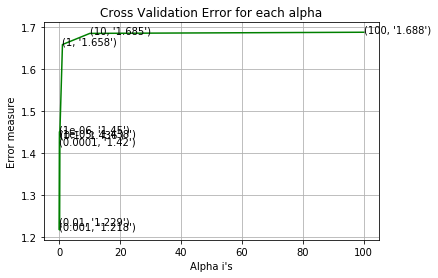

In [110]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [111]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_log_loss)



For values of best alpha =  0.001 The train log loss is: 0.6402445508715819
For values of best alpha =  0.001 The cross validation log loss is: 1.2175687234529449
For values of best alpha =  0.001 The test log loss is: 1.0615708784401328


In [112]:
model_results = pd.DataFrame([['Logistic Regression with balancing', alpha[best_alpha], train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results = results.append(model_results, ignore_index = True)
results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.269520,1.243413
1,Logistic Regression with balancing,0.001,0.640245,1.217569,1.061571


Lets test it on testing data using best alpha value

Log loss : 1.2175687234529449
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


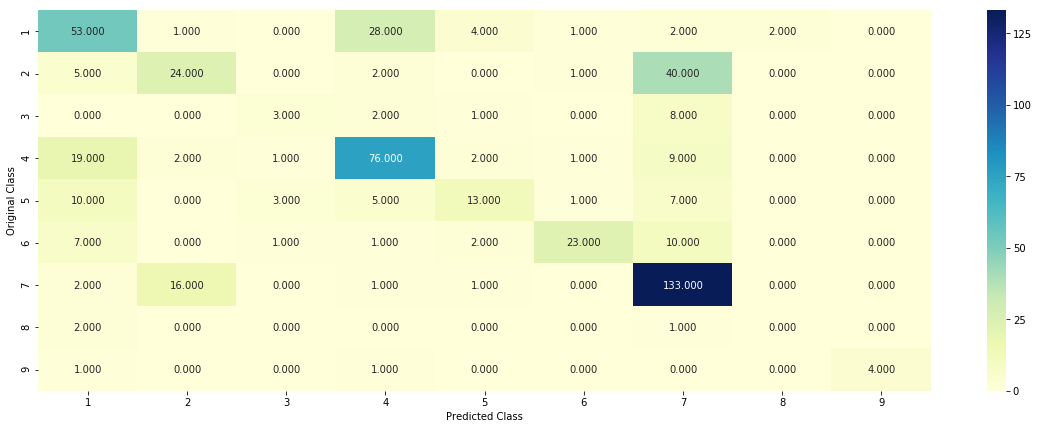

-------------------- Precision matrix (Columm Sum=1) --------------------


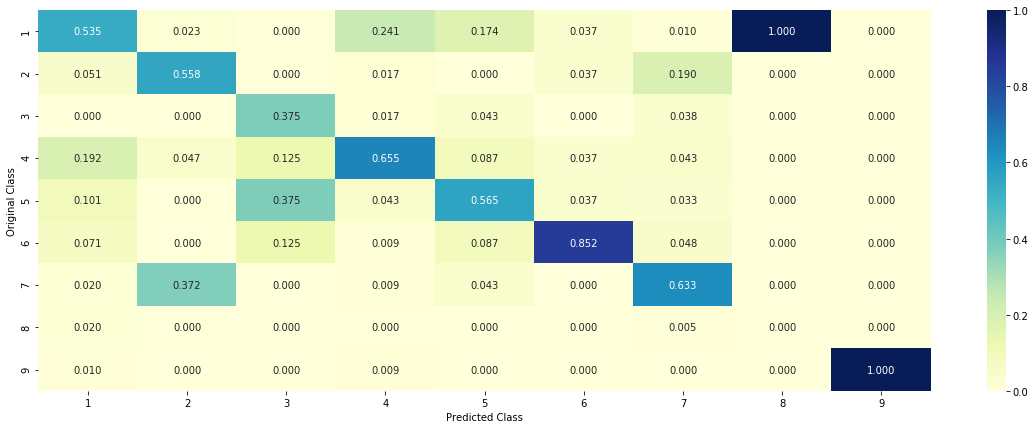

-------------------- Recall matrix (Row sum=1) --------------------


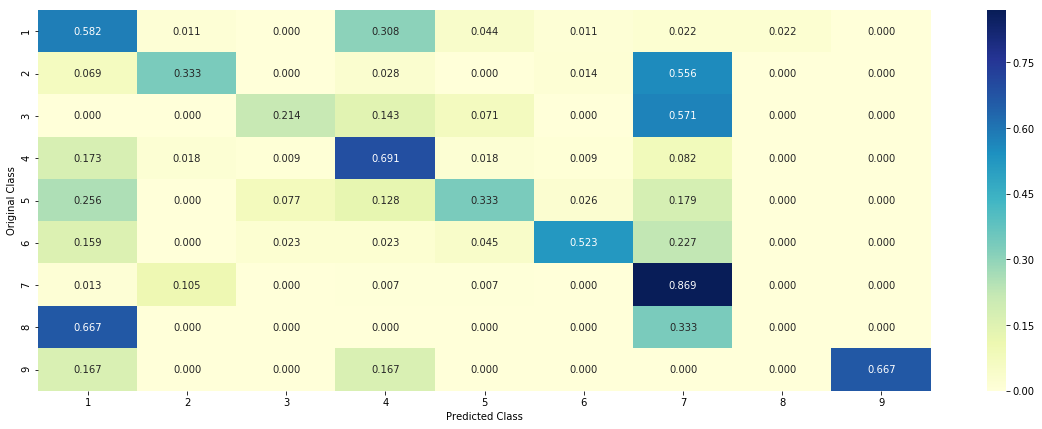

In [113]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [114]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [115]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.762e-01 4.400e-03 3.000e-04 1.600e-03 1.900e-03 1.000e-04 2.392e-01
  7.340e-02 2.900e-03]]
Actual Class : 1
--------------------------------------------------
160 Text feature [figure3c] present in test data point [True]
182 Text feature [figure5d] present in test data point [True]
369 Text feature [figure4d] present in test data point [True]
386 Text feature [thereof] present in test data point [True]
390 Text feature [premature] present in test data point [True]
443 Text feature [tsa] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [116]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0186 0.0287 0.0058 0.0126 0.0192 0.0118 0.8938 0.0058 0.0037]]
Actual Class : 7
--------------------------------------------------
22 Text feature [constitutive] present in test data point [True]
27 Text feature [constitutively] present in test data point [True]
59 Text feature [activated] present in test data point [True]
100 Text feature [activation] present in test data point [True]
101 Text feature [technology] present in test data point [True]
114 Text feature [concentrations] present in test data point [True]
121 Text feature [downstream] present in test data point [True]
159 Text feature [expressing] present in test data point [True]
179 Text feature [activating] present in test data point [True]
191 Text feature [cysteine] present in test data point [True]
201 Text feature [inhibitor] present in test data point [True]
Out of the top  500  features  11 are present in query point


## Without class balancing

In [117]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.409939368033368
for alpha = 1e-05
Log Loss : 1.3809507161969257
for alpha = 0.0001
Log Loss : 1.3581071080447695
for alpha = 0.001
Log Loss : 1.188604635283427
for alpha = 0.01
Log Loss : 1.2270464297055401
for alpha = 0.1
Log Loss : 1.4370072131080138
for alpha = 1
Log Loss : 1.6258167298889803


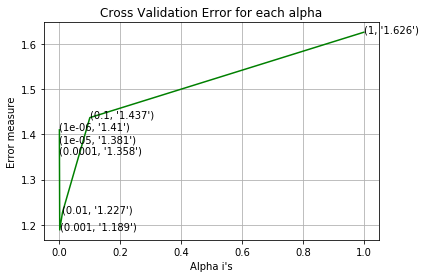

In [118]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [120]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_log_loss)



For values of best alpha =  0.001 The train log loss is: 0.6267705621325822
For values of best alpha =  0.001 The cross validation log loss is: 1.188604635283427
For values of best alpha =  0.001 The test log loss is: 1.0741504716068608


In [121]:
model_results = pd.DataFrame([['Logistic Regression without balancing', alpha[best_alpha], train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results = results.append(model_results, ignore_index = True)
results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.269520,1.243413
1,Logistic Regression with balancing,0.001,0.640245,1.217569,1.061571
2,Logistic Regression without balancing,0.001,0.626771,1.188605,1.074150


Lets test our model with best hyper param

Log loss : 1.188604635283427
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


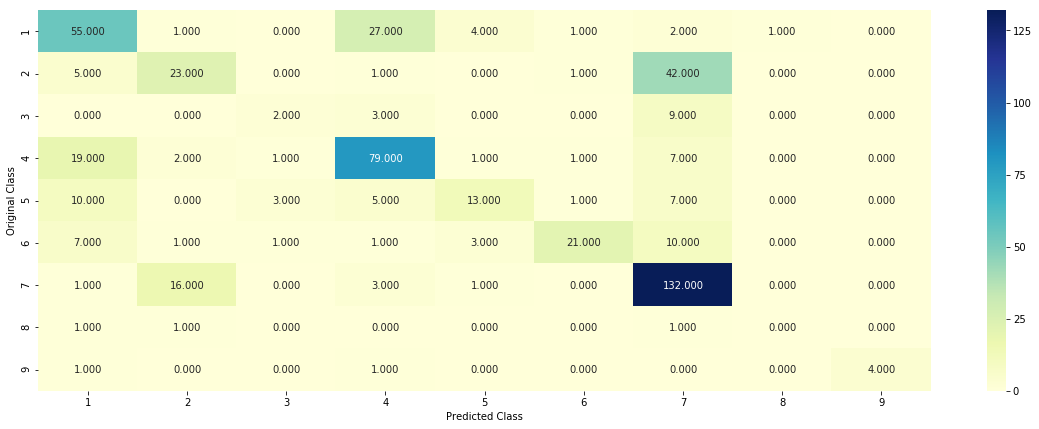

-------------------- Precision matrix (Columm Sum=1) --------------------


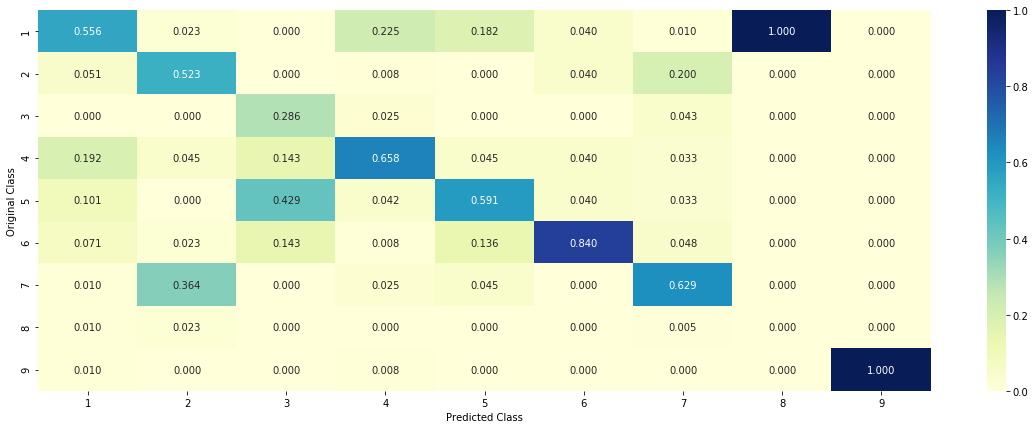

-------------------- Recall matrix (Row sum=1) --------------------


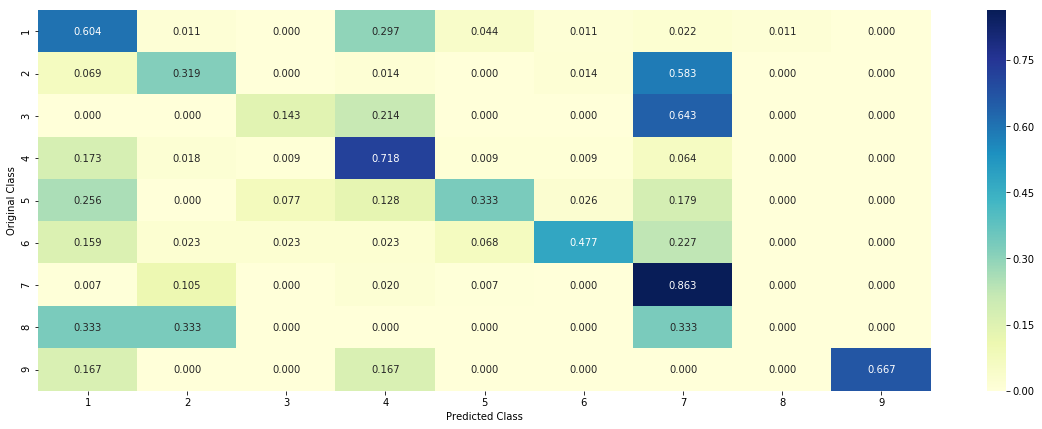

In [122]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Testing query point and interpretability

In [123]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.349e-01 2.400e-03 0.000e+00 1.700e-03 5.000e-04 0.000e+00 3.310e-01
  2.940e-02 0.000e+00]]
Actual Class : 1
--------------------------------------------------
154 Text feature [figure3c] present in test data point [True]
188 Text feature [figure5d] present in test data point [True]
305 Text feature [figure4d] present in test data point [True]
368 Text feature [thereof] present in test data point [True]
450 Text feature [figure3a] present in test data point [True]
456 Text feature [premature] present in test data point [True]
Out of the top  500  features  6 are present in query point


# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.434897839006326
for C = 0.0001
Log Loss : 1.3927239475103799
for C = 0.001
Log Loss : 1.3128072595120872
for C = 0.01
Log Loss : 1.1740715513117668
for C = 0.1
Log Loss : 1.3461494087160897
for C = 1
Log Loss : 1.678755929047788
for C = 10
Log Loss : 1.6879212335802074
for C = 100
Log Loss : 1.6879268580788478


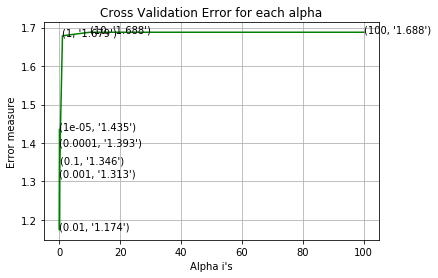

For values of best alpha =  0.01 The train log loss is: 0.7436472456393359
For values of best alpha =  0.01 The cross validation log loss is: 1.1740715513117668
For values of best alpha =  0.01 The test log loss is: 1.1065274281055215


In [124]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [126]:
best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_log_loss)

For values of best alpha =  0.01 The train log loss is: 0.7436472456393359
For values of best alpha =  0.01 The cross validation log loss is: 1.1740715513117668
For values of best alpha =  0.01 The test log loss is: 1.1065274281055215


In [127]:
model_results = pd.DataFrame([['Support Vector Machines', alpha[best_alpha], train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results = results.append(model_results, ignore_index = True)
results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.269520,1.243413
1,Logistic Regression with balancing,0.001,0.640245,1.217569,1.061571
2,Logistic Regression without balancing,0.001,0.626771,1.188605,1.074150
3,Support Vector Machines,0.010,0.743647,1.174072,1.106527


BUT the log loss is high eventhough the misclassified point is less.

### Testing model with best alpha values

Log loss : 1.1740715513117668
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


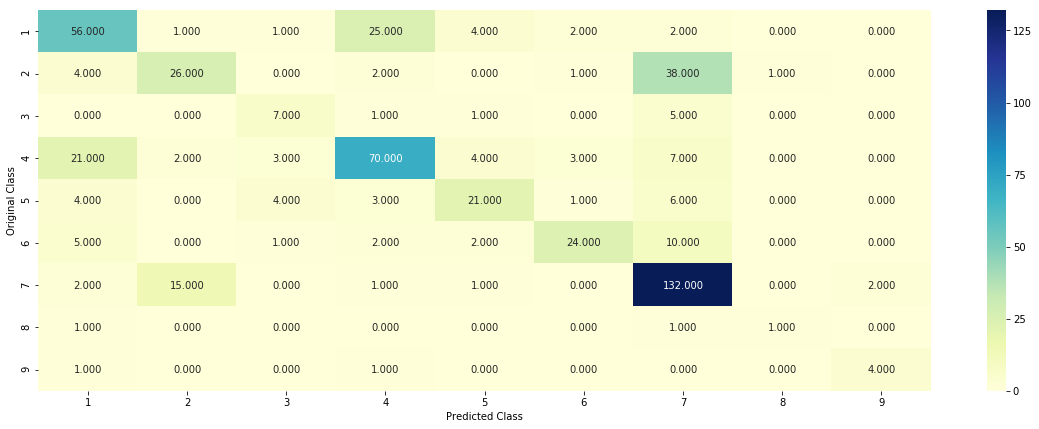

-------------------- Precision matrix (Columm Sum=1) --------------------


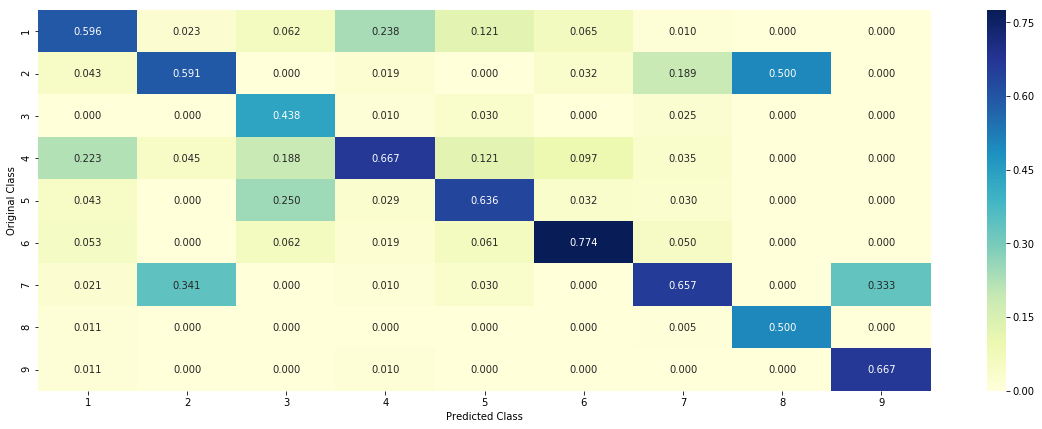

-------------------- Recall matrix (Row sum=1) --------------------


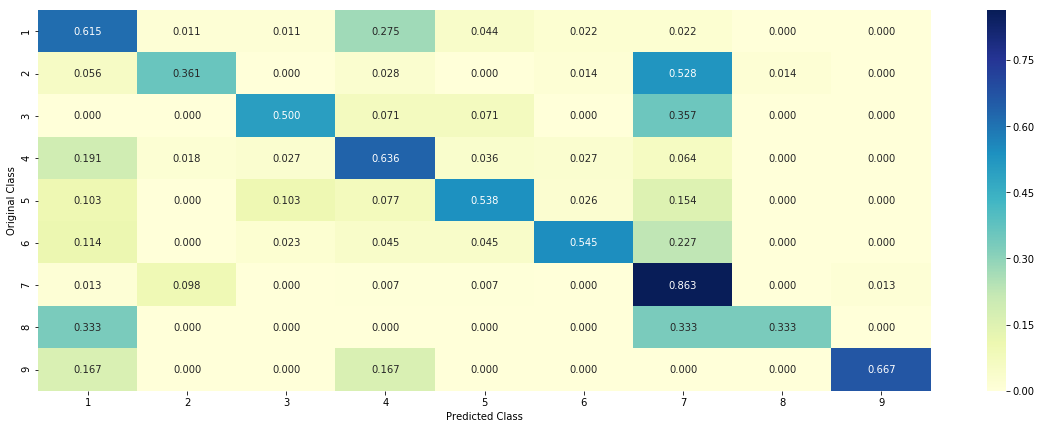

In [128]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [129]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.261e-01 7.500e-03 5.000e-04 1.220e-02 1.020e-02 6.000e-04 3.119e-01
  2.770e-02 3.300e-03]]
Actual Class : 1
--------------------------------------------------
48 Text feature [figure3c] present in test data point [True]
54 Text feature [figure5d] present in test data point [True]
147 Text feature [thereof] present in test data point [True]
209 Text feature [premature] present in test data point [True]
230 Text feature [bb] present in test data point [True]
421 Text feature [seminal] present in test data point [True]
Out of the top  500  features  6 are present in query point


# Random Forest Classifier

## Model with One hot encoder

In [130]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.267880135130869
for n_estimators = 100 and max depth =  10
Log Loss : 1.1960231124007634
for n_estimators = 200 and max depth =  5
Log Loss : 1.2424325497140103
for n_estimators = 200 and max depth =  10
Log Loss : 1.1898625997739014
for n_estimators = 500 and max depth =  5
Log Loss : 1.2370925588821486
for n_estimators = 500 and max depth =  10
Log Loss : 1.1830133758204913
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2294606603028397
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1781994790556043
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2261846399366931
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1775598431125356


In [132]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",test_log_loss)

For values of best estimator =  2000 The train log loss is: 0.6969742071369123
For values of best estimator =  2000 The cross validation log loss is: 1.1775598431125354
For values of best estimator =  2000 The test log loss is: 1.1281427682438891


In [133]:
model_results = pd.DataFrame([['Random Forest', "-", train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results = results.append(model_results, ignore_index = True)
results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.269520,1.243413
1,Logistic Regression with balancing,0.001,0.640245,1.217569,1.061571
2,Logistic Regression without balancing,0.001,0.626771,1.188605,1.074150
3,Support Vector Machines,0.01,0.743647,1.174072,1.106527
4,Random Forest,-,0.696974,1.177560,1.128143


Lets test it on testing data using best hyper param

Log loss : 1.1775598431125356
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix --------------------


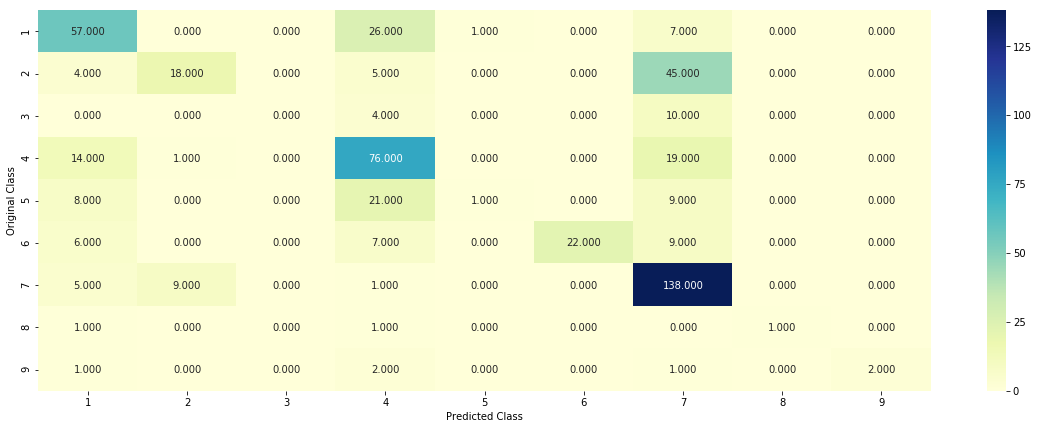

-------------------- Precision matrix (Columm Sum=1) --------------------


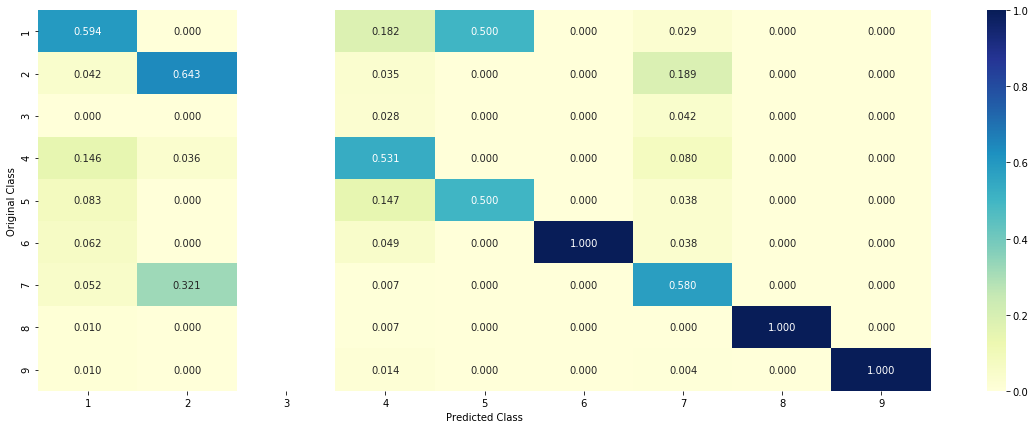

-------------------- Recall matrix (Row sum=1) --------------------


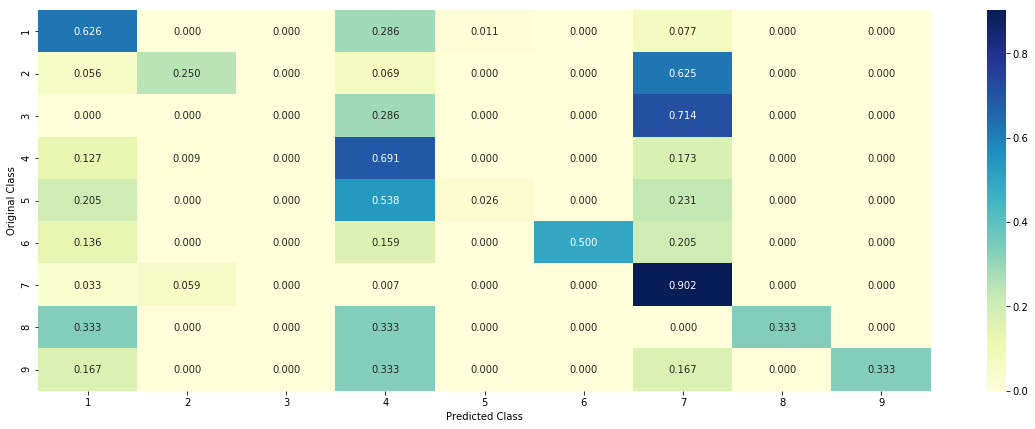

In [134]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [135]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1745 0.1267 0.0159 0.0815 0.0431 0.0381 0.504  0.0057 0.0103]]
Actual Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [missense] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [constitutive] present in test data point [True]
9 Text feature [oncogenic] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [activated] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
13 Text feat

# K Nearest Neighbour Classification

In [136]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.2648808358710477
for alpha = 11
Log Loss : 1.3258352512964944
for alpha = 15
Log Loss : 1.3246385857648495
for alpha = 21
Log Loss : 1.3477065860124704
for alpha = 31
Log Loss : 1.3928247819489672
for alpha = 41
Log Loss : 1.4072656048405852
for alpha = 51
Log Loss : 1.3883146076703587
for alpha = 99
Log Loss : 1.3583108722943453


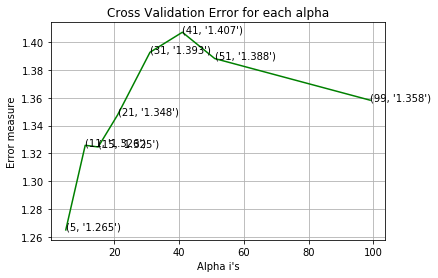

In [137]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [139]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_log_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_log_loss)

For values of best alpha =  5 The train log loss is: 0.9611812452284425
For values of best alpha =  5 The cross validation log loss is: 1.2648808358710477
For values of best alpha =  5 The test log loss is: 1.2514372893169448


Log loss : 1.2648808358710477
Number of mis-classified points : 0.4323308270676692
-------------------- Confusion matrix --------------------


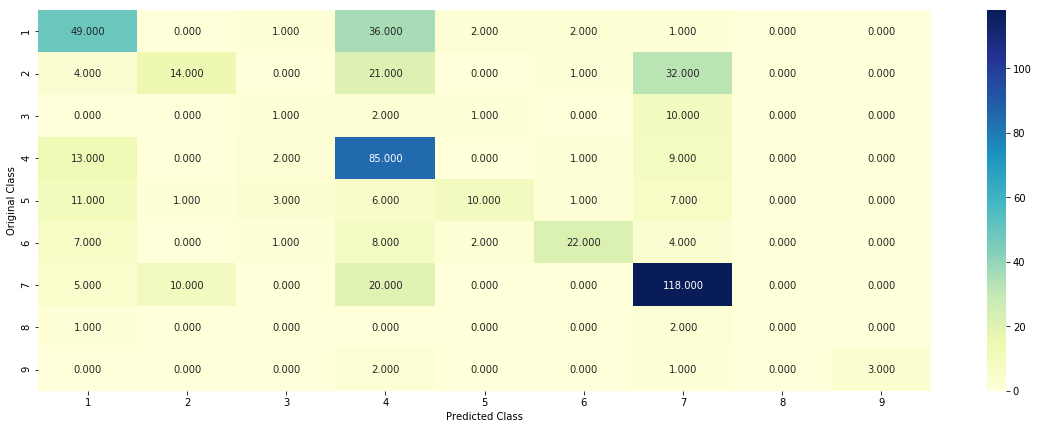

-------------------- Precision matrix (Columm Sum=1) --------------------


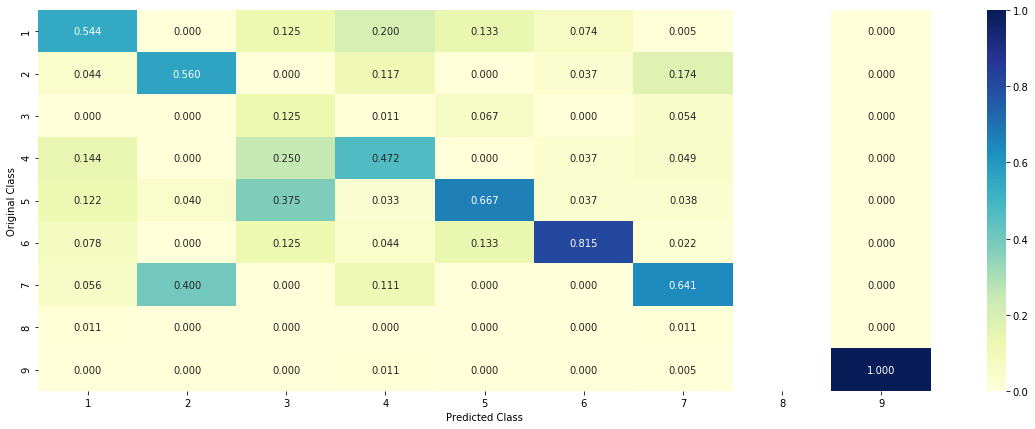

-------------------- Recall matrix (Row sum=1) --------------------


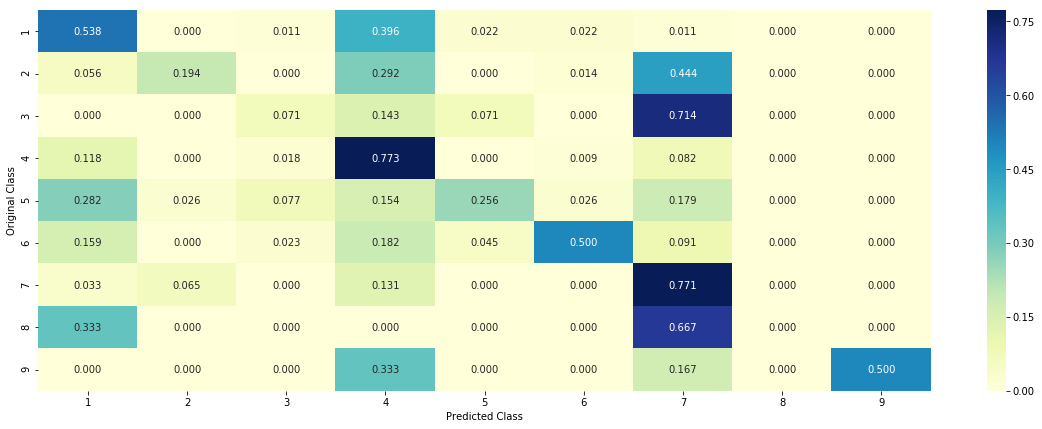

In [141]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [142]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


In [143]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


In [140]:
model_results = pd.DataFrame([['KNN', alpha[best_alpha], train_log_loss,cv_log_loss,test_log_loss]]
,columns = ['Model', 'Best Alpha', 'train log loss', 'cross validation log loss', 'test log loss'])

results = results.append(model_results, ignore_index = True)
results

,Model,Best Alpha,train log loss,cross validation log loss,test log loss
0,Naive Bayes,0.001,0.861182,1.269520,1.243413
1,Logistic Regression with balancing,0.001,0.640245,1.217569,1.061571
2,Logistic Regression without balancing,0.001,0.626771,1.188605,1.074150
3,Support Vector Machines,0.01,0.743647,1.174072,1.106527
4,Random Forest,-,0.696974,1.177560,1.128143
5,KNN,5,0.961181,1.264881,1.251437


From this we can able to infer that Logistic Regression With balancing and without balancing has the lowest log loss but in terms of accuracy Linear support vector machines has the lowest number accuracy in misclassified points .